In [1]:
%%javascript
$(document).ready(() => {
    // Удаление данного блока кода с конечного результата.
    $('div.code_cell').first().css('display', 'none');

    // Включение автоматического переноса слов в параграфе.
    $('div.text_cell p').css('hyphens', 'auto');

    // Включение растягивания текста на всю доступную длину.
    $('div.text_cell p').css('text-align', 'justify');
});

<IPython.core.display.Javascript object>

<h3><b>Лабораторная работа №11: Криптографические атаки с помощью машинного обучения</b></h3>

<p lang="ru">Физически неклонируемая функция — это функция, воплощённая в физической структуре, которую просто оценить, но трудно охарактеризовать или воспроизвести. Физическая структура такой функции состоит из множества случайных компонентов. Эти случайные компоненты вводятся в ходе производственного процесса и неконтролируемы. Такие функции представляют собой физическую систему, которая при воздействии на неё порождает уникальные и непредсказуемые ответы. Специфический вызов и соответствующий ему ответ вместе образуют некоторую пару. Несмотря на относительную новизну данной концепции, научное сообщество уже успело изучить их проблемы. Одной из основных проблем, которая показана на примере физически неклонируемых функций на основе памяти, является нестабильность некоторых из значений, что вынуждает разработчиков прибегать к кодам коррекции ошибок и более надежным архитектурам. С другой стороны, наличие очень высокой стабильности подвергает функцию риску криптографической атаки с помощью методов машинного обучения.</p>

In [2]:
%autosave 300

Autosaving every 300 seconds


In [3]:
import warnings

# Игнорирование оповещающих сообщений внешних библиотек.
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
import copy
import pathlib
import zipfile

In [5]:
import numpy as np
import pandas as pd

In [6]:
# Импортирование функции для табличного форматирования.
from tabulate import tabulate

In [7]:
# Импортирование функции для чтения MATLAB файлов.
from scipy.io import loadmat

In [8]:
# Импортирование функции для разделения исходной выборки данных.
from sklearn.model_selection import train_test_split

In [9]:
# Импортирование алгоритма логистической регрессии.
from sklearn.linear_model import LogisticRegression

In [10]:
# Импортирование метода опорных векторов.
from sklearn.svm import SVC

In [11]:
# Импортирование алгоритма градиентного бустинга.
from sklearn.ensemble import GradientBoostingClassifier

In [12]:
# Импортирование функции для вычисления необходимых метрик.
from sklearn.metrics import classification_report

In [13]:
# Импортирование библиотеки для работы с графиками.
from matplotlib import pyplot
%matplotlib inline

In [14]:
# Установка начального значения для генератора случайных чисел.
# Данное действие требуется для воспроизведения результатов опыта.
np.random.seed(0)

<p lang="ru"><b>Пункт №1:&nbsp;</b>Загрузка всех предоставленных наборов данных в память при помощи внешней библиотеки scipy. Текущие наборы данных содержат информацию о запросах и ответах для физически неклонируемых функций с разным количеством мультиплексоров.</p>

In [15]:
def load_data(path):
    data = loadmat(path)

    data_x = np.array(data['X'])
    data_y = np.array(data['y']).ravel()

    return data_x, data_y  

In [16]:
# Поиск предоставленных наборов данных.
for path in pathlib.Path('datasets').glob('**/*.zip'):

    # Распаковка всех предоставленных наборов данных.
    with zipfile.ZipFile(path) as fin:
        fin.extractall('datasets')

In [17]:
%%time

datasets = {
    path.stem: load_data(path)

    # Поиск предоставленных наборов данных.
    for path in pathlib.Path('datasets').glob('**/*.mat')
}

CPU times: user 581 ms, sys: 512 ms, total: 1.09 s
Wall time: 1.13 s


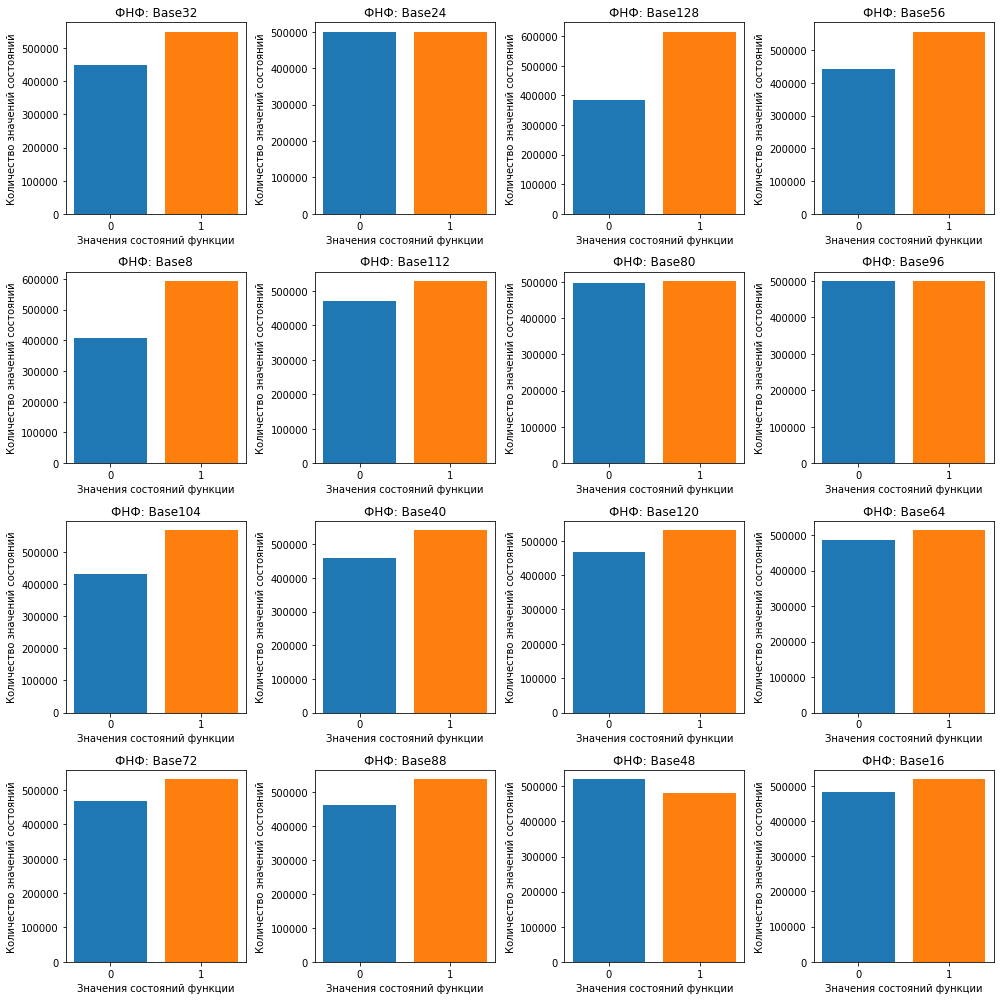

In [18]:
# Создание совместного полотна для графиков.
figure = pyplot.figure(figsize=(14, 14))

for num, func_name in enumerate(datasets):
    # Загрузка запросов и ответов рассматриваемой функции.
    x, y = copy.deepcopy(datasets[func_name])

    # Вычисление количества состояний мультиплексоров функции.
    values, counts = np.unique(y, return_counts=True)

    # Создание текущего полотна для графика.
    ax = figure.add_subplot(4, 4, num+1)

    # Построение столбчатой диаграммы состояний.
    ax.bar(str(values[0]), counts[0])
    ax.bar(str(values[1]), counts[1])

    # Настройка заглавия графика.
    ax.set_title('ФНФ: {}'.format(func_name))

    # Настройка координатных осей графика.
    ax.set_xlabel('Значения состояний функции')
    ax.set_ylabel('Количество значений состояний')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show(figure)

<p lang="ru"><b>Пункт №2:&nbsp;</b>Реализация функции подготовки запросов физически неклонируемых функций для обучения математических моделей. Значения состояний мультиплексоров в любой физически неклонируемой функции могут принимать только значения $0$ или $1$, что соотвествует переключению в новое состояние рассматриваемого устройства. Такие значения в машинном обучении являються неуместным, так как излишнее их количество в выборке исключает корректное обновление весовых коэффициентов. Возникнувшая ситуация решается путем замены некорректных значений состояний мультиплексоров и пересчетом сигнала функции с учетом новых значений.</p>

In [19]:
def prepare(x):
    # Создание результирующего контейнера.
    res = np.zeros(x.shape)

    # Преобразование показателей мультиплексоров.
    # Если: 0 => +1 (Не было переключения).
    # Если: 1 => -1 (Было переключение).
    x[x == 1] = -1
    x[x == 0] = +1

    for i in range(x.shape[0]):
        # Инициализация запроса.
        c = x[i]

        # Сохранение состояния первого мультиплексора.
        res[i][0] = c[0]

        # Вычисление остальных сигналов функции.
        for ii in range(1, c.shape[0]):
            res[i][ii] = res[i][ii-1] * c[ii]

    return res

In [20]:
# Загрузка запросов и ответов рассматриваемой функции.
data_x, data_y = copy.deepcopy(datasets['Base16'])

In [21]:
# Нормализация признаков выборки.
data_norm = prepare(data_x)

In [22]:
# Создание тренировочной и контрольной выборки данных.
x_train, x_tests, y_train, y_tests = train_test_split(data_norm, data_y)

In [23]:
%%time

# Запуск оптимизации математической модели.
model = GradientBoostingClassifier().fit(x_train, y_train)

CPU times: user 2min, sys: 1.17 s, total: 2min 1s
Wall time: 2min 4s


In [24]:
# Вычисление значения необходимых метрик обученной математической модели.
print(classification_report(y_tests, model.predict(x_tests)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    120275
           1       0.99      0.98      0.99    129725

    accuracy                           0.99    250000
   macro avg       0.99      0.99      0.99    250000
weighted avg       0.99      0.99      0.99    250000



<p lang="ru"><b>Пункт №3:&nbsp;</b>Применение нескольких алгоритмов машинного обучения к заданным функциям. Данное действие необходимо для визуальной оценки зависимости корректности полученных математических моделей от размеров тренировочной выборки функции. После построения графиков можно заметить, что величина выборки в поставленной задаче сильно влияет на корректность модели.</p>

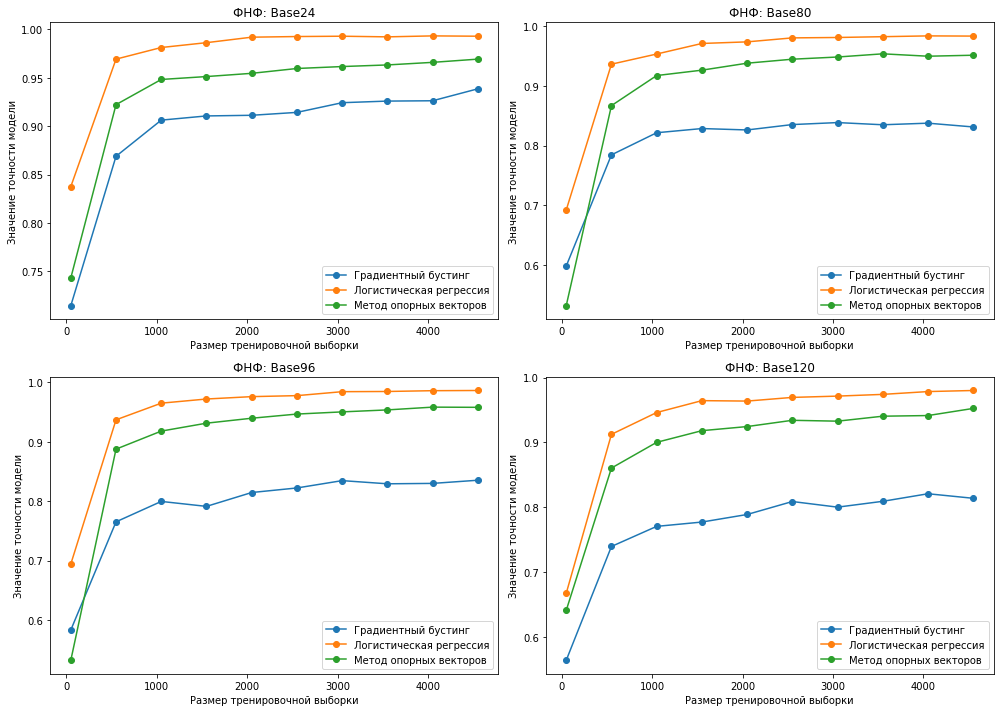

In [25]:
# Создание совместного полотна для графиков.
figure = pyplot.figure(figsize=(14, 10))

for num, func_name in enumerate(['Base24', 'Base80', 'Base96', 'Base120']):
    # Загрузка запросов и ответов рассматриваемой функции.
    x, y = copy.deepcopy(datasets[func_name])

    # Нормализация признаков выборки.
    x = prepare(x)

    scores = []
    for size in range(50, 5000, 500):
        # Создание тренировочной выборки.
        train_x = x[:size] 
        train_y = y[:size]

        # Создание контрольной выборки.
        tests_x = x[size:size+3000]
        tests_y = y[size:size+3000]

        # Оптимизация модели градиентного бустинга.
        model0 = GradientBoostingClassifier().fit(train_x, train_y)

        # Оптимизация модели логистической регрессии.
        model1 = LogisticRegression().fit(train_x, train_y)

        # Оптимизация модели опорных векторов.
        model2 = SVC().fit(train_x, train_y)

        scores.append([
            size,
            model0.score(tests_x, tests_y),
            model1.score(tests_x, tests_y),
            model2.score(tests_x, tests_y),
        ])

    # Преобразование вектора результатов.
    scores = np.asarray(scores)

    # Создание текущего полотна для графика.
    ax = figure.add_subplot(2, 2, num+1)

    # Построение графика роста точности от размеров тренировочной выборки.
    ax.plot(scores[:, 0], scores[:, 1], label='Градиентный бустинг', marker='o')
    ax.plot(scores[:, 0], scores[:, 2], label='Логистическая регрессия', marker='o')
    ax.plot(scores[:, 0], scores[:, 3], label='Метод опорных векторов', marker='o')

    # Настройка заглавия графика.
    ax.set_title('ФНФ: {}'.format(func_name))

    # Настройка координатных осей графика.
    ax.set_xlabel('Размер тренировочной выборки')
    ax.set_ylabel('Значение точности модели')

    # Построение легенды графика.
    ax.legend(loc='best')

# Настройка отображения.
pyplot.tight_layout()

# Отображение графика.
pyplot.show(figure)

<p lang="ru"><b>Пункт №4:&nbsp;</b>Применение нескольких алгоритмов машинного обучения к заданным функциям. Данное действие необходимо для визуальной оценки зависимости корректности полученных математических моделей от размеров рассматриваемых функций. После построения графиков можно заметить, что численность мультиплексоров функции в поставленной задаче сильно влияет на корректность модели.</p>

In [26]:
scores = []
for func_name in ['Base16', 'Base64', 'Base104', 'Base128']:
    # Загрузка запросов и ответов рассматриваемой функции.
    x, y = copy.deepcopy(datasets[func_name])

    x = x[:50000]
    y = y[:50000]

    # Нормализация признаков выборки.
    x = prepare(x)

    # Создание тренировочной и контрольной выборки данных.
    train_x, tests_x, train_y, tests_y = train_test_split(x, y)

    # Оптимизация модели градиентного бустинга.
    model0 = GradientBoostingClassifier().fit(train_x, train_y)

    # Оптимизация модели логистической регрессии.
    model1 = LogisticRegression().fit(train_x, train_y)

    # Оптимизация модели опорных векторов.
    model2 = SVC().fit(train_x, train_y)

    scores.append([
        func_name,
        model0.score(tests_x, tests_y),
        model1.score(tests_x, tests_y),
        model2.score(tests_x, tests_y),
    ])

In [27]:
# Настройка заголовков рассматриваемой таблицы.
headers = ['Function', 'Gradient Boosting', 'Logistic Regression', 'Support Vector Machine']

# Вывод результатов точности полученных математических моделей.
print(tabulate(scores, tablefmt='presto', floatfmt='.5f', headers=headers))

 Function   |   Gradient Boosting |   Logistic Regression |   Support Vector Machine
------------+---------------------+-----------------------+--------------------------
 Base16     |             0.98136 |               0.99488 |                  0.99344
 Base64     |             0.88448 |               0.99216 |                  0.97168
 Base104    |             0.83720 |               0.99120 |                  0.97544
 Base128    |             0.79712 |               0.98976 |                  0.97160
